<div align="right" style="text-align: right"><i>Peter Norvig<br>2012, 2020</i></div>

# The Unfinished Game ... of Risk

![](components_.jpg)

[Keith Devlin](https://web.stanford.edu/~kdevlin/)'s [book](https://www.amazon.com/Unfinished-Game-Pascal-Fermat-Seventeenth-Century/dp/0465018963) [*The Unfinished Game*](https://wordplay.blogs.nytimes.com/2015/12/14/devlin-unfinished-game/) describes how Fermat and Pascal discovered the rules of probability that guide gambling in games. The question they confront is: what if a gambling game is interrupted, but one player is in the lead by a certain score. How much of the pot should the leader get?

My friends and I faced a similar question when a game of [Risk](https://www.ultraboardgames.com/risk/game-rules.php) ran on too long (as they often do) and we were unable to finish. Player **A** had just cashed in cards and added troops to a single large force in Brazil that was poised to make a sweeping attack on player **B**, whose territories were situated in Africa and Asia in such a way that **A** could attack North Africa first and then go from one territory to the next without ever having to branch off.  We wrote down the number of **A**'s armies in Brazil, **72**, and the number of armies in **B**'s successive territories: **22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1.** What is the probability that **A** can capture all these territories?

______

# Monte Carlo Simulation

We can answer the question with a [**Monte Carlo simulation**](https://en.wikipedia.org/wiki/Monte_Carlo_method) that follows the rules of Risk and uses random numbers to roll the dice. First some preliminaries:

In [1]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import random

attackers   = 72
territories = (22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1)

die = (1, 2, 3, 4, 5, 6)
Die = int # a type alias

random.seed(42) # For reproducability

How many territories and how many total defenders?

In [2]:
len(territories), sum(territories)

(14, 60)

It looks fairly even: the attackers have 12 more armies, 72 to 60, but they will have to leave an army in each of the 14 territories along the way. 

# Battless, Invasions, and Campaigns

In Risk a **battle** consists of a one-time roll of some dice and the resulting loss of armies. The attacker will roll three dice if possible (but can roll a maximum of the number of armies in the attacking territory minus one) and the defender will roll two dice if possible (or only one if they have only one army remaining). We compare the highest die on each side, with the defender losing an army if the attacker's die is higher, and the attacker losing an army if tied or lower. Then if both sides rolled at least two dice, we do the same comparison with the second highest die on each side. The function `deaths` returns a tuple of (number of attacking armies that die, number of defending armies that die). 

In [3]:
def deaths(attack_dice: List[Die], defend_dice: List[Die]) -> Tuple[int, int]:
    """The number of (attackers, defenders) who die due to this roll."""
    dead = [0, 0]
    for a, d in zip(sorted(attack_dice, reverse=True), 
                    sorted(defend_dice, reverse=True)):
        dead[a > d] += 1
    return tuple(dead)

In [4]:
def test1() -> bool:
    # Four examples from www.ultraboardgames.com/risk/game-rules.php
    assert deaths([6, 1, 1], [3])    == (0, 1) # 6 beats 3, so defender loses 1
    assert deaths([6, 2, 1], [3, 2]) == (1, 1) # 6 beats 3, but 2 ties 2, so 1 loss each
    assert deaths([3, 3],    [4, 3]) == (2, 0) # 3 loses to 4, and attacker 3 loses to 3
    assert deaths([6],       [5, 4]) == (0, 1) # 6 beats 5, so defender loses 1
    return True
    
test1()

True

An **invasion** consists of a series of battles until either the defenders are all defeated (in which case the attacker can move armies into the captured territory, but must leave one army behind), or the attackers have fewer than two armies left, and can no longer attack. 

A **campaign** consists of a sequence of invasions, designed to capture all the defender's territories.
In the function `campaign`, the variable `attackers` tracks the number of attackers invading the current territory. (The total number of armies for the attacking side will in general be more than `attackers`, because there will be one army left behind in each captured territory.) If `verbose` is true, we'll `say` what is happening along the way. In the end, return the number of `attackers` in the final territory minus the total number of defenders still alive. This will be positive if all the defenders have been defeated, and nonpositive if not.

In [5]:
def campaign(attackers: int, territories: List[int], verbose=True) -> int:
    """Given a number of armies for attacker and a list of territory army sizes for defender,
    randomly play to the end, and return remaining attackers minus remaining defenders."""
    for t, defenders in enumerate(territories, 1):
        if verbose: say(attackers, 'attack', defenders, t)
        while attackers > 1 and defenders > 0:
            A, D = deaths(roll(min(3, attackers - 1)), 
                          roll(min(2, defenders)))
            attackers -= A
            defenders -= D
        if attackers == 1:
            if verbose: say(attackers, "can't beat", defenders, t)
            break
        attackers -= 1 # Capture a new territory, leave one behind
    return attackers - (defenders + sum(territories[t:]))

def say(attackers, action, defenders, t):
    """Say what is happening."""
    print(f'{attackers:3} armies {action} {defenders:2} defenders in territory {t}')
        
def roll(n) -> List[Die]: 
    """A random roll of `n` dice, sorted largest first."""
    return sorted((random.choice(die) for _ in range(n)), reverse=True)

# The Answer

Let's answer the question of who wins the unfinished game:

In [6]:
campaign(attackers, territories)

 72 armies attack 22 defenders in territory 1
 48 armies attack  8 defenders in territory 2
 44 armies attack  2 defenders in territory 3
 40 armies attack  2 defenders in territory 4
 35 armies attack  2 defenders in territory 5
 33 armies attack  7 defenders in territory 6
 23 armies attack  1 defenders in territory 7
 22 armies attack  1 defenders in territory 8
 20 armies attack  3 defenders in territory 9
 19 armies attack  1 defenders in territory 10
 17 armies attack  2 defenders in territory 11
 16 armies attack  3 defenders in territory 12
 15 armies attack  5 defenders in territory 13
 13 armies attack  1 defenders in territory 14


12

The attackers won, capturing all the territories and moving 12 remaining armies into the final territory.

But that was just one simulation; other simulations could have different results. Let's summarize, say, 100,000 simulations, see how long it takes, and plot a histogram of the resulting scores:

In [7]:
%time scores = [campaign(attackers, territories, False) for _ in range(100000)]

CPU times: user 33.1 s, sys: 70.9 ms, total: 33.1 s
Wall time: 33.2 s


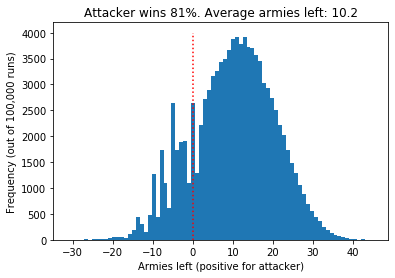

In [8]:
def summary(scores):
    """Summarize the scores from simulations."""
    P = np.average([s > 0 for s in scores])    
    N, avg = len(scores), np.average(scores)
    title = f'Attacker wins {P:.0%}. Average armies left: {avg:.1f}'
    plt.ylabel(f'Frequency (out of {N:,d} runs)'); 
    plt.xlabel('Armies left (positive for attacker)')
    plt.hist(scores, bins=max(scores) - min(scores) + 1)
    plt.plot([0, 0], [0, N/25], 'r:'); plt.title(title)
    
summary(scores)

We see that the attackers win 81% of the time, and the scores look roughly like a bell-shaped curve, but with a non-normal pattern on the left side. What's causing the non-normal pattern? Note that the number of defenders in the final four territories are `(2, 3, 5, 1)`, and the width of the four spikes on the left are `(1, 2, 4, 1)`, one less than the number of defenders (except for the last spike). I think there are spikes rather than a smooth curve because it is doubly-difficult to capture a territory: you need to have two armies left, not just one, so that you can leave one behind. 

# Exact Probabilities

By repeatedly running a simulation, we can get approximate probabilities. But what if we wanted **exact probabilities** (at least exact under the assumption that the dice are exactly fair and that floating point roundoff is not an issue)? I'll start by defining the function `outcomes`, so that, for example, `outcomes(3, 2)` returns a Counter of all possible outcomes of rolling 3 attacker dice versus 2 defender dice; each outcome is a pair of `(attacker_deaths, defender_deaths)` and has a count of how often it occurred.

In [9]:
from functools   import lru_cache
from collections import Counter
import itertools

@lru_cache()
def outcomes(num_A: int, num_D: int) -> List[Tuple[int, int]]:
    """All (equiprobable) outcomes of (attacker_deaths, defender_deaths)
    from rolling num_A dice versus num_D dice."""
    return Counter(deaths(dice[:num_A], dice[num_A:])
                   for dice in itertools.product(die, repeat=num_A + num_D))

In [10]:
outcomes(3, 2)

Counter({(2, 0): 2275, (1, 1): 2611, (0, 2): 2890})

The result for `outcomes(3, 2)` says that the attackers lose two armies in 2,275 out of the $6^5 = 7,776$ different outcomes; the defenders lose two in 2,890 outcomes; and they each lose one in the remaining 2,611 outcomes. I found a [web page](http://datagenetics.com/blog/november22011/) that lists the results for all six possible battles (attackers roll 1, 2, or 3 dice; defenders roll 1 or 2); let's verify that our `outcomes` agree with theirs:

In [11]:
def test2() -> bool:
    # See http://datagenetics.com/blog/november22011/
    assert outcomes(1, 1) == {(1, 0):   21, (0, 1):   15}
    assert outcomes(2, 1) == {(1, 0):   91, (0, 1):  125}
    assert outcomes(3, 1) == {(1, 0):  441, (0, 1):  855}
    assert outcomes(1, 2) == {(1, 0):  161, (0, 1):   55}
    assert outcomes(2, 2) == {(2, 0):  581, (1, 1):  420, (0, 2):  295}
    assert outcomes(3, 2) == {(2, 0): 2275, (1, 1): 2611, (0, 2): 2890}
    return True
    
test2()

True

Now we know exact outcomes for a single roll of the dice; what about an invasion where $A$ attackers keep attacking until they defeat $D$ defenders (or all but one attacker dies trying)? The function `winP(A, D)` gives the probability of the attackers winning. It works recursively. The two base cases are that the probability is zero if the attackers don't have at least two armies and the probability is one if the defenders have no armies. 

In the recursive case we observe the possible outcomes for the first battle, and then compute the win probability for the invasion as the average, over every possible outcome of the dice rolls, of the win probability for the number of remaining attackers and defenders after the battle, weighted by the number of times that the outcome occurs. (We use `np.average` because it accepts an optional `weights` argument.)

In [12]:
@lru_cache(None)
def winP(attackers: int, defenders: int) -> float:
    """The probability that `attackers` can invade and defeat all the `defenders`."""
    if attackers <= 1:
        return 0
    elif defenders == 0:
        return 1
    else:
        battle = outcomes(min(3, attackers - 1), min(2, defenders))
        return np.average([winP(attackers - A, defenders - D) for (A, D) in battle],
                          weights=list(battle.values()))

Let's try a simple example: `winP(2, 1)` should be `15/36`, the same as the probability of the attacker prevailing in `outcomes(2, 1)`:

In [13]:
winP(2, 1) == 15/36

True

What's the probability that 12 attackers successfully invade 10 defenders?

In [14]:
winP(12, 10)

0.6538260547697077

Let's make a chart, with the number of defenders varying from 1 to 60, and the number of attackers separated into eight cases (depicted as eight lines), where in each case there are Δ more attackers than defenders, for Δ = -5, -2, 0, 1, 2, 5, and 10:

In [15]:
def chart(Ds=range(1, 61), deltas=(-5, -2, -1, 0, 1, 2, 5, 10)):
    plt.figure(figsize=(9, 6)); plt.grid()
    plt.title('Each line: attackers with Δ more armies than defenders')
    plt.xlabel('Number of Defenders'); plt.ylabel('Win Probability for Attackers')
    for delta in reversed(deltas):
        Ps = [winP(max(0, D + delta), D) for D in Ds]
        plt.plot(Ds, Ps, '.-', label=f'Δ={delta}')
    plt.legend()

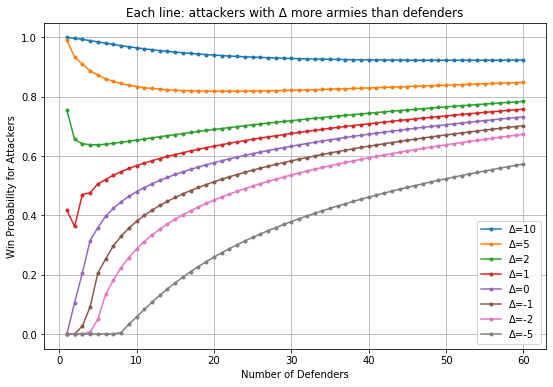

In [16]:
chart()

Note that the purple line (fourth from bottom), where the number of attackers exactly equals the number of defenders, gives a low win probability for a small attacking force, but reaches 50% for 12-on-12, and 73% for 60-on-60. The red line, where the attackers have one more army than the defenders, dips from one to two defenders but is over 50% for a 6-on-5 attack. Similarly, the green line, where the attackers have a surplus of two armies, dips sharply from 75% to 66% as the number of defenders goes from 1 to 2, dips slightly more for 3 and 4 defenders, and then starts to rise. So overall, an attacker does not need a big advantage in armies as long as there are many armies on both sides. Even when the attacker is at a disadvantage in numbers (as in the bottom grey line where the attacker has five fewer armies), the attacker can still have an advantage in win probability; `winP(55, 60)` is about 57%.

# Simulation versus Exact Computation

Let's see how the exact computation compares with a simulation:

In [17]:
A, D = 32, 30

exact = winP(A, D)
simul = np.average([campaign(A, [D], False) > 0 for _ in range(10000)])

exact, simul

(0.7194339370737594, 0.7178)

We see that they give similar results, differing by one or two parts per thousand. So when would you prefer a simulation, and when an exact computation?

**Advantages of a simulation:**
- Usually simpler to code; can use an `if` statement to distinguish two branches; don't have to follow every branch.
- Can be more efficient to compute; don't have to spend a lot of computation time on extremely rare events.
- Can handle event sequences of potentially unbounded length.

**Advantages of an exact calculation:**
- Don't need to rerun multiple times; don't need statistical inference to analyze the range of outcomes.
- If a very rare event can be extremely bad (or good), it is important to know exactly how likely the rare event is. 

I chose to use a **simulation** for `campaign` because:
- I thought it would be easier to code.
- I would be happy with only four bits of accuracy: enough to determine the win percentage within 6%. (I ended up running enough simulations to get within 1%.) 
- I didn't care about the 1-in-a-billion chance of, say, the attackers losing 17 battles in a row; I just want to know the overall odds of the attackers losing the campaign.  (Note that if I was doing a simulation of a nuclear reactor, I would certainly be very concerned with a 1-in-a-billion chance of a meltdown, and would need to code ways of exploring that possibility more carefully.)
- A simulation is more flexible. Consider a small change to the rules of Risk: if the dice show five 1s in a battle, both sides add one army. We can easily implement that in a simulation in two or three lines of code, and the effect on run time will be negligible, because it only happens one in 7,776 times. But in an exact calculation this new rule would change everything: it would become an infinite game, and we would have to make a wholesale rearrangement of the code to deal with that. 

I chose to use **exact calculation** for `winP` because:
- I knew the computational demands would be very small either way.
- I saw there was something going on with odd/even number of armies, and I wanted to distinguish slight variations that are real from slight variations that are random, so getting exact numbers was useful.


(*Note:* I call it an "exact" calculation, but it is actually limited to the precision of 64-bit floating point numbers. If you truly need an exact answer for a discrete combinatorics problem, do division with the `fraction.Fraction` class, not with `float`. And of course it is an exact computation in the model; if the model does not reflect the world, the results will be wrong.)